In [7]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from PIL import Image
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score,classification_report, confusion_matrix
import matplotlib.pyplot as plt
# Device setup
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Using GPU: {gpus[0]}")
else:
    print("Using CPU")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Config
DATA_DIR = '/kaggle/input/plantvillage-dataset/color'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 5
SEED = 42

In [3]:
# Diccionario de modelos
models = { 
    "VGG19": tf.keras.applications.VGG19,
    "MobileNetV2": tf.keras.applications.MobileNetV2,
    "EfficientNetB0": tf.keras.applications.EfficientNetB0,
    "ResNet50": tf.keras.applications.ResNet50,
}

## Carga y preprocesamiento de datos

En esta sección preparo el dataset PlantVillage para entrenamiento, validación y testeo.  
Armo un DataFrame con el path de cada imagen y su clase, y luego hago un split estratificado en tres conjuntos: training (70%), validation (15%) y test (15%).  
Esto me permite tener un test set “blind” que nunca toco durante el desarrollo y comparar performance real al final.

Uso `ImageDataGenerator` para crear generadores de imágenes desde el DataFrame, aplicando augmentations y normalización en el training set, y solo normalización en validación y test.  
Hago resize a 224x224 para compatibilidad con los modelos preentrenados.

**Conclusión:**  
Dejo todo listo para transfer learning con una separación de datos profesional y reproducible, usando los pipelines estándar de Keras.


In [4]:
classes = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
rows = []
for cls in classes:
    folder = os.path.join(DATA_DIR, cls)
    for img in os.listdir(folder):
        if img.lower().endswith('.jpg'):
            rows.append({'filename': os.path.join(folder, img), 'class': cls})

df = pd.DataFrame(rows)

In [5]:
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['class'], random_state=42)

print(f"Train: {len(train_df)} Val: {len(val_df)} Test: {len(test_df)}")

Train: 38012 Val: 8145 Test: 8146


In [8]:
# Data augmentations + rescale
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen_val = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)

train_gen = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
val_gen = datagen_val.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)
test_gen = datagen_test.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 38012 validated image filenames belonging to 38 classes.
Found 8145 validated image filenames belonging to 38 classes.
Found 8146 validated image filenames belonging to 38 classes.


In [10]:
MODEL_NAME = "VGG19"

In [11]:
VGG19_WEIGHTS = "/kaggle/input/vgg/tensorflow2/default/1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

## Configuración del modelo base preentrenado

Armo el modelo usando un backbone preentrenado (VGG19).  
Cargo los pesos preentrenados.
Congelo los pesos del modelo base al principio, así solo entreno la capa personalizada.

**Conclusión:**  
Esto me permite aprovechar el conocimiento aprendido en ImageNet y tener un baseline fuerte con poco entrenamiento.


In [13]:
inputs = tf.keras.Input(shape=(*IMG_SIZE, 3))
base_model = models[MODEL_NAME](
    include_top=False,
    weights=None,
    input_tensor=inputs
)
base_model.load_weights(VGG19_WEIGHTS) 
base_model.trainable = False

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(len(train_gen.class_indices), activation='softmax')(x)


model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [14]:
# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy", tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,175,910 (76.96 MB)

 Trainable params: 150,886 (589.40 KB)

 Non-trainable params: 20,025,024 (76.39 MB)

## Entrenamiento rápido en un subset

Para no perder tiempo y asegurar que todo el pipeline funciona, primero entreno el modelo en un subset pequeño del training set (por ejemplo, 10% de los datos).  
Esto acelera las pruebas iniciales y permite detectar bugs de data o errores de shape sin esperar horas.

**Conclusión:**  
Una vez validado el pipeline, paso a entrenar sobre el dataset completo.


In [15]:
# Entrenar con el 10% de los datos de train en cada epoch
subset_ratio = 0.1
steps = int(np.ceil(train_gen.samples * subset_ratio / BATCH_SIZE))

history_subset = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    steps_per_epoch=steps
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1753651795.945709     107 service.cc:148] XLA service 0x7a2ac0005c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753651795.947275     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1753651795.947298     107 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1753651796.812725     107 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1753651810.888205     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.1726 - loss: 3.5853 - precision: 0.4620 - recall: 0.0575 - val_accuracy: 0.4058 - val_loss: 2.9742 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4438 - loss: 2.1188 - precision: 0.7877 - recall: 0.2318 - val_accuracy: 0.4878 - val_loss: 2.2167 - val_precision: 0.9962 - val_recall: 0.0652
Epoch 3/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.5120 - loss: 1.7751 - precision: 0.7968 - recall: 0.3013 - val_accuracy: 0.6118 - val_loss: 1.5694 - val_precision: 0.9759 - val_recall: 0.2435
Epoch 4/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.5391 - loss: 1.6065 - precision: 0.7976 - recall: 0.3489 - val_accuracy: 0.6983 - val_loss: 1.0943 - val_precision: 0.9045 - val_recall: 0.4735
Epoch 5/5
119/119 ━━━━━━━━━━━━━━━━━━━━ 116s 980ms/step - accuracy: 0.6217 - loss: 1.3563 - precision: 0.8394 - recall: 0.4375 - val_accuracy: 0.7595 - val_loss: 0

In [16]:
val_loss, val_acc, val_prec, val_recall = model.evaluate(val_gen)
print(f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}  Prec: {val_prec:.4f}  Recall: {val_recall:.4f}")


255/255 ━━━━━━━━━━━━━━━━━━━━ 67s 263ms/step - accuracy: 0.7610 - loss: 0.8565 - precision: 0.9042 - recall: 0.5700
Val Loss: 0.8706  Acc: 0.7595  Prec: 0.9106  Recall: 0.5688


In [17]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}  Acc: {test_acc:.4f}  Prec: {test_prec:.4f}  Recall: {test_recall:.4f}")


255/255 ━━━━━━━━━━━━━━━━━━━━ 78s 308ms/step - accuracy: 0.7540 - loss: 0.8795 - precision: 0.9047 - recall: 0.5664
Test Loss: 0.8933  Acc: 0.7470  Prec: 0.9000  Recall: 0.5614


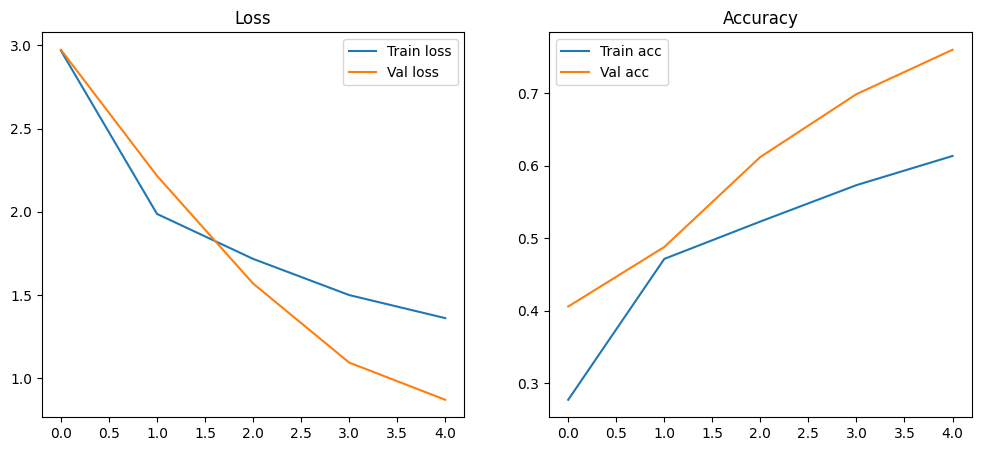

In [18]:
def plot_history(history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Val loss')
    plt.title("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='Train acc')
    plt.plot(history.history['val_accuracy'], label='Val acc')
    plt.title("Accuracy")
    plt.legend()
    plt.show()

plot_history(history_subset)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

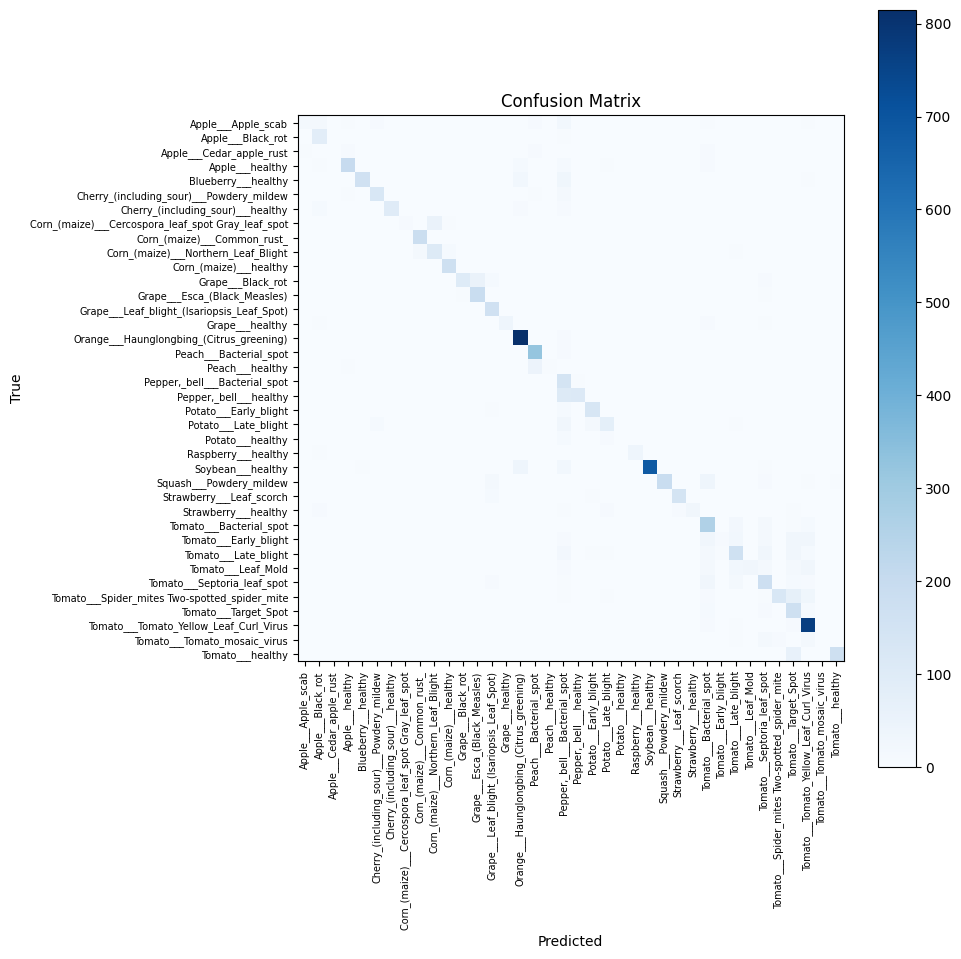

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.607     0.179     0.276        95
                                 Apple___Black_rot      0.587     0.903     0.712        93
                          Apple___Cedar_apple_rust      0.000     0.000     0.000        41
                                   Apple___healthy      0.865     0.805     0.834       246
                               Blueberry___healthy      0.953     0.716     0.817       225
          Cherry_(including_sour)___Powdery_mildew      0.796     0.791     0.794       158
                 Cherry_(including_sour)___healthy      0.960     0.758     0.847       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.800     0.104     0.184        77
                       Corn_(maize)___Common_rust_      0.895     1.000     0.945       179
               Corn_(maize)___Northern_Leaf_Blight      0.658     0.716     0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
# Obtener predicciones y labels verdaderos del validation set
val_gen.reset()  # Para asegurar orden correcto
y_true = []
y_pred = []
for i in range(len(val_gen)):
    x_batch, y_batch = val_gen[i]
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))
    # Si ya predecimos todo, salimos
    if (i+1)*BATCH_SIZE >= val_gen.samples:
        break

# Nombres de las clases
class_names = list(val_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,10))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=7)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=7)
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=3)
print(report)


In [20]:
metrics = {
    'accuracy': val_acc,
    'precision': val_prec,
    'recall': val_recall,
    'f1': f1_score(y_true, y_pred, average='weighted')
}
metrics_df = pd.DataFrame([metrics])
print(metrics_df.to_markdown(index=False))


|   accuracy |   precision |   recall |       f1 |
|-----------:|------------:|---------:|---------:|
|   0.759484 |    0.910574 | 0.568815 | 0.745807 |


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

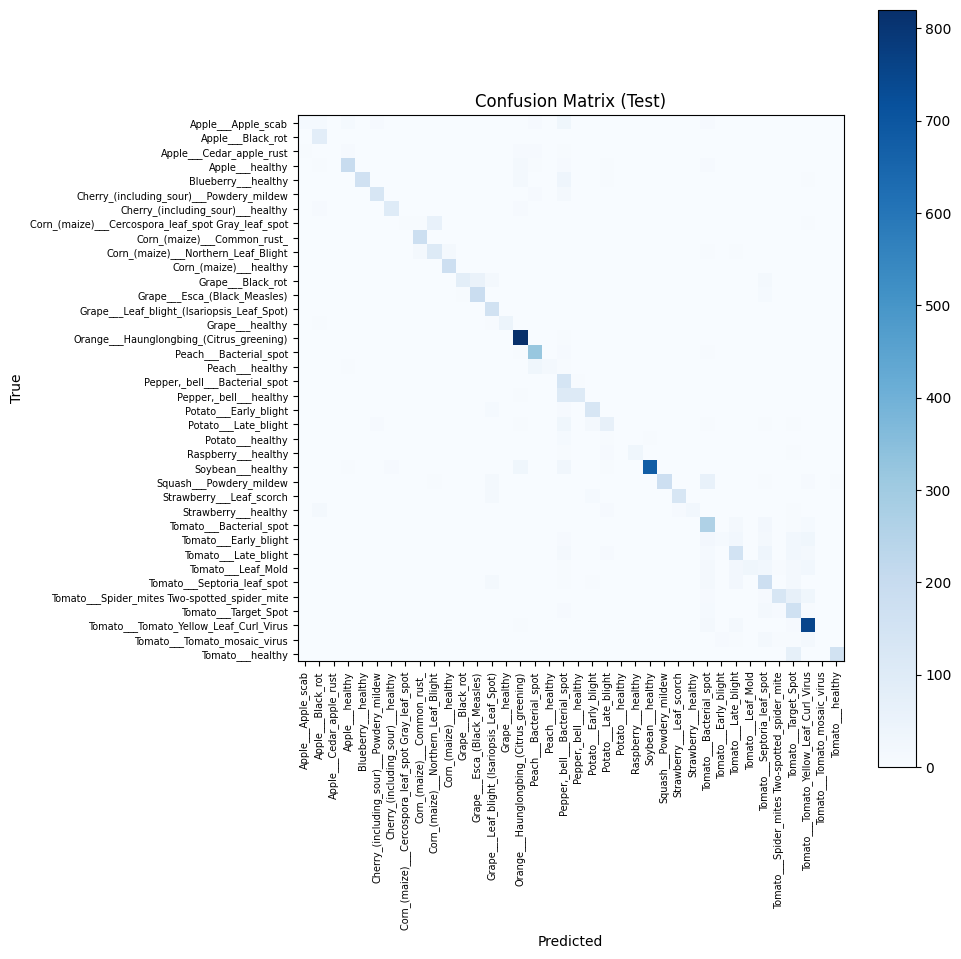

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.688     0.117     0.200        94
                                 Apple___Black_rot      0.613     0.903     0.730        93
                          Apple___Cedar_apple_rust      0.000     0.000     0.000        41
                                   Apple___healthy      0.852     0.794     0.822       247
                               Blueberry___healthy      0.970     0.717     0.824       226
          Cherry_(including_sour)___Powdery_mildew      0.825     0.835     0.830       158
                 Cherry_(including_sour)___healthy      0.927     0.797     0.857       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.667     0.052     0.096        77
                       Corn_(maize)___Common_rust_      0.898     0.989     0.941       179
               Corn_(maize)___Northern_Leaf_Blight      0.591     0.707     0.6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
test_gen.reset()
y_true_test, y_pred_test = [], []
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch)
    y_true_test.extend(np.argmax(y_batch, axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))
    if (i+1)*BATCH_SIZE >= test_gen.samples:
        break

class_names = list(test_gen.class_indices.keys())

# Matriz de confusión
cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10,10))
plt.imshow(cm_test, cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=7)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=7)
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification report (test)
report_test = classification_report(y_true_test, y_pred_test, target_names=class_names, digits=3)
print(report_test)

In [22]:
metrics_test = {
    'accuracy': test_acc,
    'precision': test_prec,
    'recall': test_recall,
    'f1': f1_score(y_true_test, y_pred_test, average='weighted')
}
metrics_test_df = pd.DataFrame([metrics_test])
print(metrics_test_df.to_markdown(index=False))


|   accuracy |   precision |   recall |       f1 |
|-----------:|------------:|---------:|---------:|
|   0.746992 |     0.90002 |  0.56138 | 0.734088 |


## Entrenamiento final y validación

Con el pipeline validado, entreno el modelo sobre el training set completo y valido usando el validation set separado al principio.  
Registro métricas de accuracy, precisión y recall para comparar fácilmente con futuros experimentos o modelos más complejos.

**Conclusión:**  
Esto me da una baseline sólida y reproducible para comparar mejoras futuras.


In [23]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 681s 573ms/step - accuracy: 0.6627 - loss: 1.1433 - precision: 0.8314 - recall: 0.5049 - val_accuracy: 0.8161 - val_loss: 0.5905 - val_precision: 0.8978 - val_recall: 0.7530
Epoch 2/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 560s 472ms/step - accuracy: 0.7245 - loss: 0.8803 - precision: 0.8391 - recall: 0.6217 - val_accuracy: 0.7899 - val_loss: 0.6335 - val_precision: 0.8649 - val_recall: 0.7297
Epoch 3/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 551s 464ms/step - accuracy: 0.7536 - loss: 0.7992 - precision: 0.8494 - recall: 0.6631 - val_accuracy: 0.8754 - val_loss: 0.3987 - val_precision: 0.9249 - val_recall: 0.8276
Epoch 4/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 583s 491ms/step - accuracy: 0.7678 - loss: 0.7494 - precision: 0.8545 - recall: 0.6888 - val_accuracy: 0.8744 - val_loss: 0.3911 - val_precision: 0.9207 - val_recall: 0.8330
Epoch 5/5
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 554s 466ms/step - accuracy: 0.7712 - loss: 0.7279 - precision: 0.8566 - recall: 0.6960 - val_accura

## Evaluación y visualización de resultados

Al finalizar el entrenamiento, evalúo el modelo en el validation set.  
Muestro una tabla de métricas clave (accuracy, precision, recall) y grafico la matriz de confusión para ver qué clases se confunden más.  
También grafico la evolución de la loss y la accuracy durante el entrenamiento.

**Conclusión:**  
Esto me permite entender de manera visual y numérica cómo se comporta el modelo y dónde puede mejorar.


In [24]:
# Evaluate
val_loss, val_acc, val_prec, val_recall = model.evaluate(val_gen)
print(f"Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}  Prec: {val_prec:.4f}  Recall: {val_recall:.4f}")

# Save
model.save('plantvillage_baseline_model.h5')
np.save('class_names.npy', train_gen.class_indices)

255/255 ━━━━━━━━━━━━━━━━━━━━ 67s 263ms/step - accuracy: 0.8308 - loss: 0.5041 - precision: 0.8968 - recall: 0.7844
Val Loss: 0.5236  Acc: 0.8285  Prec: 0.8951  Recall: 0.7777


In [25]:
test_loss, test_acc, test_prec, test_recall = model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}  Acc: {test_acc:.4f}  Prec: {test_prec:.4f}  Recall: {test_recall:.4f}")


255/255 ━━━━━━━━━━━━━━━━━━━━ 67s 263ms/step - accuracy: 0.8294 - loss: 0.5385 - precision: 0.8892 - recall: 0.7724
Test Loss: 0.5393  Acc: 0.8283  Prec: 0.8916  Recall: 0.7702


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

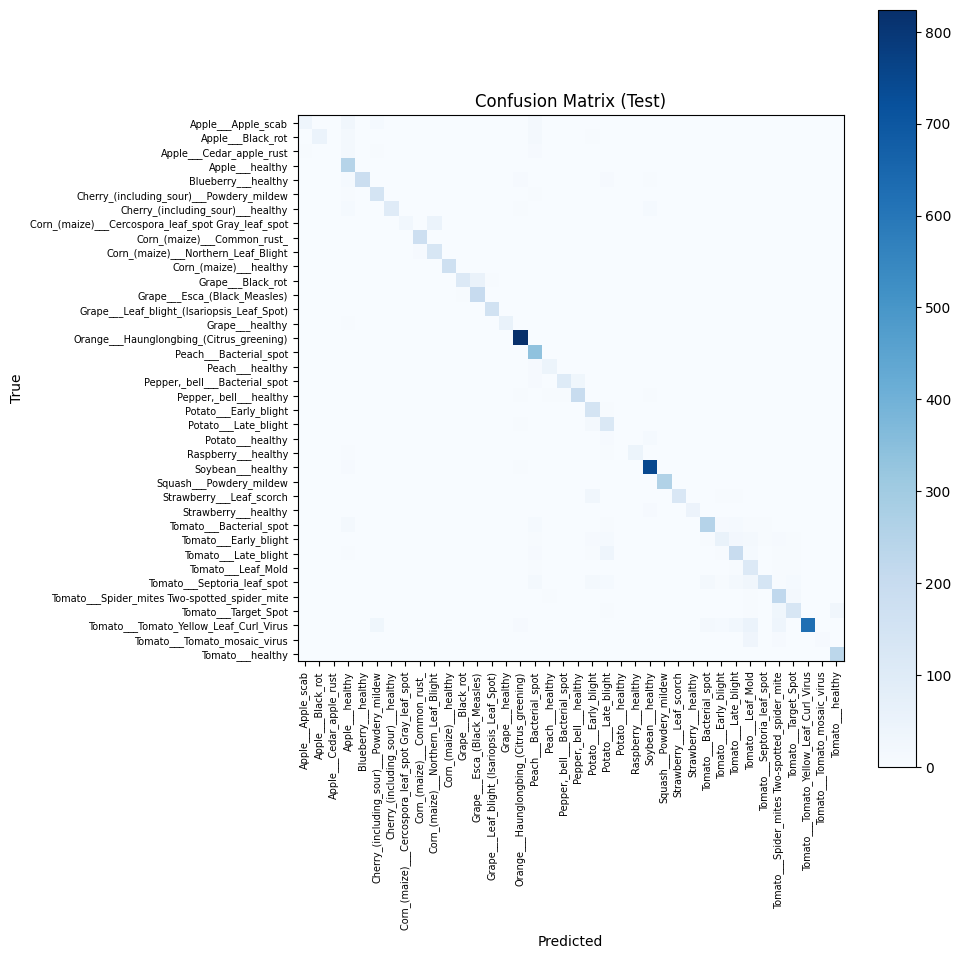

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab      0.804     0.394     0.529        94
                                 Apple___Black_rot      0.980     0.527     0.685        93
                          Apple___Cedar_apple_rust      1.000     0.049     0.093        41
                                   Apple___healthy      0.614     0.992     0.759       247
                               Blueberry___healthy      0.989     0.810     0.891       226
          Cherry_(including_sour)___Powdery_mildew      0.717     0.930     0.810       158
                 Cherry_(including_sour)___healthy      1.000     0.766     0.867       128
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      0.893     0.325     0.476        77
                       Corn_(maize)___Common_rust_      0.937     0.989     0.962       179
               Corn_(maize)___Northern_Leaf_Blight      0.704     0.891     0.7

In [26]:
test_gen.reset()
y_true_test, y_pred_test = [], []
for i in range(len(test_gen)):
    x_batch, y_batch = test_gen[i]
    preds = model.predict(x_batch)
    y_true_test.extend(np.argmax(y_batch, axis=1))
    y_pred_test.extend(np.argmax(preds, axis=1))
    if (i+1)*BATCH_SIZE >= test_gen.samples:
        break

class_names = list(test_gen.class_indices.keys())

# Matriz de confusión
cm_test = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10,10))
plt.imshow(cm_test, cmap='Blues')
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=90, fontsize=7)
plt.yticks(np.arange(len(class_names)), class_names, fontsize=7)
plt.colorbar()
plt.tight_layout()
plt.show()

# Classification report (test)
report_test = classification_report(y_true_test, y_pred_test, target_names=class_names, digits=3)
print(report_test)

In [27]:
metrics_test = {
    'accuracy': test_acc,
    'precision': test_prec,
    'recall': test_recall,
    'f1': f1_score(y_true_test, y_pred_test, average='weighted')
}
metrics_test_df = pd.DataFrame([metrics_test])
print(metrics_test_df.to_markdown(index=False))


|   accuracy |   precision |   recall |       f1 |
|-----------:|------------:|---------:|---------:|
|   0.828259 |    0.891573 | 0.770194 | 0.823089 |


## Conclusión final del modelo baseline

Entrené un modelo baseline sobre el dataset completo de PlantVillage utilizando transfer learning con VGG19 como feature extractor.  
Evalué la performance sobre el test set, que nunca fue usado durante el entrenamiento ni el tuning de hiperparámetros.

Los resultados finales obtenidos en el test set son:

- **Test Loss:** 0.5393
- **Accuracy:** 0.8283
- **Precision:** 0.8916
- **Recall:** 0.7702
- **F1-score:** 0.8231

|   accuracy |   precision |   recall |       f1 |
|-----------:|------------:|---------:|---------:|
|   0.8283   |    0.8916   | 0.7702   | 0.8231   |

**Conclusión:**  
El modelo baseline logra una accuracy del 82.8% y un F1-score de 82.3% sobre el test set, mostrando buen poder de generalización para una primera iteración sin tuning profundo.  
La precisión elevada indica que los errores suelen ser falsos negativos antes que falsos positivos, lo cual puede ser relevante para futuras aplicaciones donde evitar diagnósticos erróneos es clave.  
Estos resultados establecen una referencia sólida para comparar futuros modelos y mejoras (más datos, augmentations, fine-tuning, modelos más modernos, etc.).

